In [1]:
import torch
import numpy as np
import scipy
import libsvm
import libsvmdata
import networkx as nx

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

In [4]:
X, y = libsvmdata.fetch_libsvm('abalone_scale')
X.shape, y.shape

((4177, 8), (4177,))

In [5]:
X = torch.tensor(X)
y = torch.tensor(y)

In [6]:
from decentralized.topologies import Topologies

In [7]:
from oracles.binary_svc_oracle import BinarySVC
from oracles.l1_regression_oracle import L1RegressionOracle

In [8]:
def get_oracles(X, y, n, grad_type):
    result = []
    start = 0
    step = X.shape[0] // n
    for tmp in range(n):
        result.append(L1RegressionOracle(X[start:start + step], y[start:start + step], grad_type=grad_type))
        start += step
    return result

In [9]:
from methods.centralized_gd import CentralizedGradientDescent
from methods.decentralized_gd import DecentralizedGradientDescent
from methods.ZOSADOM import ZOSADOM

In [10]:
def to_list_of_loss(logs):
    result = []
    for el in logs:
        result.append(el["loss"])
    return result

In [11]:
max_iter = 30000
topology = "full"
n_nodes = 100

In [23]:
%%time
optimizer = ZOSADOM(
    get_oracles(X, y, n_nodes, "grad"),#"smoothed-two-point"),
    Topologies(n_nodes, topology, "gossip-laplacian"),
    max_iter
)
optimizer.run(log=True)
nsadom_loss = to_list_of_loss(optimizer.logs)

CPU times: user 27min 16s, sys: 2.48 s, total: 27min 18s
Wall time: 25min 44s


In [13]:
%%time
optimizer = DecentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "mixing-laplacian"),
    0.01,
    max_iter
)
optimizer.run(log=True)
dgd_loss = to_list_of_loss(optimizer.logs)

CPU times: user 25min 24s, sys: 2.65 s, total: 25min 27s
Wall time: 24min 2s


In [14]:
%%time
optimizer = CentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "mixing-laplacian"),
    0.01,
    max_iter
)
optimizer.run(log=True)
cgd_loss = to_list_of_loss(optimizer.logs)

CPU times: user 18min 46s, sys: 935 ms, total: 18min 47s
Wall time: 18min 49s


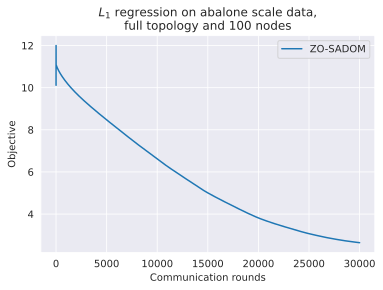

In [24]:
plt.plot(np.arange(max_iter + 1), nsadom_loss, label="ZO-SADOM")
# plt.plot(np.arange(max_iter + 1), dgd_loss, label="Decentralized GD")
# plt.plot(np.arange(max_iter + 1), cgd_loss, label="Centralized GD")
plt.title(r"$L_1$ regression on abalone scale data," + f"\n{topology} topology and {n_nodes} nodes")
plt.xlabel("Communication rounds")
plt.ylabel("Objective")
plt.legend()
plt.savefig("1.svg")
plt.show()